In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load specific rows from CSV file
data = pd.read_csv('datos-17001.csv', skiprows=range(1, 2), nrows=942, delimiter=';')
#drop the column date
data = data.drop('date', axis=1)


from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Select all columns except 'RefSt'
columns_to_standardize = [col for col in data.columns if col != 'RefSt']

# Fit and transform the data
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

print(data.head())
X = data


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


   RefSt  Sensor_O3      Temp    RelHum
0   15.0  -1.169474  0.084531  0.032385
1   19.0  -1.155044  0.466171 -0.468918
2   26.0  -1.118282  0.688665 -0.660082
3   34.0  -1.058864  0.810728 -0.742964
4   47.0  -0.900460  0.954422 -0.780395


The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
c:\Users\usalv\anaconda3\envs\newenv\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, RelHum, Temp, Sensor_O3, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.889566521018607, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\usalv\AppData\Local\Temp\ipykernel_18924\810983337.py:20: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=['Sensor_O3', 'Temp', 'RelHum', 'Intercept'])
c:\Users\usalv\anaconda3\envs\newenv\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'Sensor_O3'}>,
        <Axes: title={'center': 'Sensor_O3'}>],
       [<Axes: title={'center': 'Temp'}>,
        <Axes: title={'center': 'Temp'}>],
       [<Axes: title={'center': 'RelHum'}>,
        <Axes: title={'center': 'RelHum'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

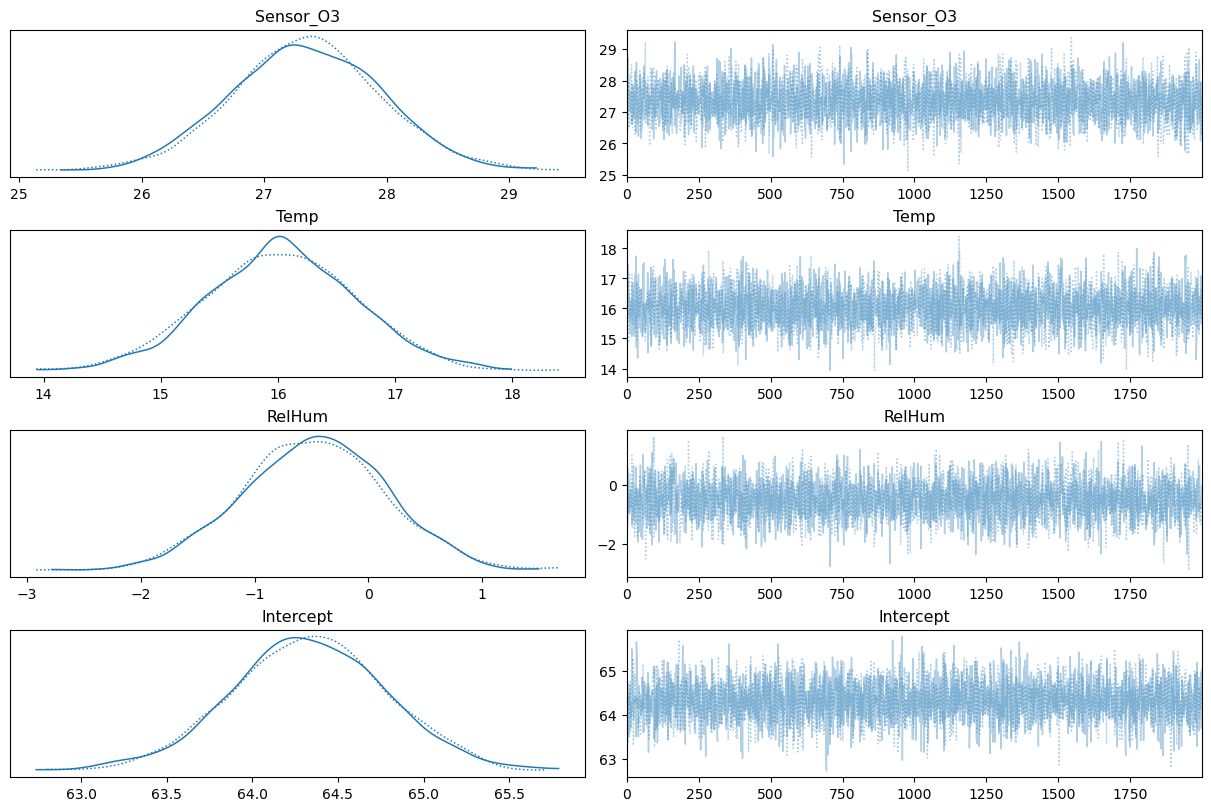

In [2]:

import pymc3 as pm

# Assuming X is a pandas DataFrame containing your data
# X = pd.DataFrame({
#     'Sensor_O3': [...],
#     'Temp': [...],
#     'RelHum': [...],
#     'RefSt': [...]
# })

with pm.Model() as model:
    # Define the GLM
    pm.glm.GLM.from_formula('RefSt ~ Sensor_O3 + Temp + RelHum', X, family=pm.glm.families.Normal())

    # draw posterior samples using NUTS sampling
    trace = pm.sample(2000, tune=1000, cores=1)

# You can analyze the trace (posterior samples) using PyMC3's plot_trace function
#add different colors in the trace plot
pm.traceplot(trace, var_names=['Sensor_O3', 'Temp', 'RelHum', 'Intercept'])


In [3]:
print(trace.varnames)
# Assuming `trace` is the trace of your model
summary = pm.summary(trace, hdi_prob=0.95)  # 95% HPD

# Print the summary
print(summary)

['Intercept', 'Sensor_O3', 'Temp', 'RelHum', 'sd_log__', 'sd']


c:\Users\usalv\anaconda3\envs\newenv\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  64.331  0.447    63.484     65.236      0.007    0.005    4290.0   
Sensor_O3  27.349  0.603    26.149     28.512      0.009    0.006    4447.0   
Temp       16.028  0.633    14.802     17.302      0.009    0.007    4543.0   
RelHum     -0.485  0.633    -1.674      0.766      0.010    0.008    3867.0   
sd         13.627  0.321    12.990     14.260      0.005    0.004    3716.0   

           ess_tail  r_hat  
Intercept    2573.0    1.0  
Sensor_O3    3074.0    1.0  
Temp         3075.0    1.0  
RelHum       3072.0    1.0  
sd           2763.0    1.0  


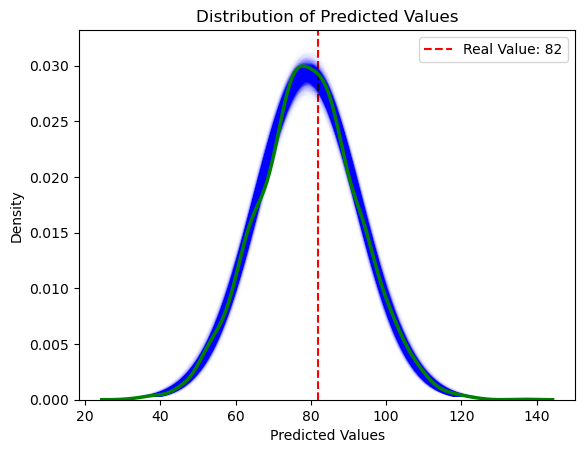

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


def predict_sensor_reading(reading, trace):
    
    # Extracting samples
    theta0_samples = trace['Intercept']
    theta1_samples = trace['Sensor_O3']
    theta2_samples = trace['Temp']
    theta3_samples = trace['RelHum']
    sigma_samples = trace['sd']
    # Predictive mean for each sample in the trace
    mu_pred = theta0_samples + theta1_samples * reading[0] + theta2_samples * reading[1] + theta3_samples * reading[2]
    # Generate predictive samples
    predictive_samples = np.random.normal(mu_pred, sigma_samples)
    return predictive_samples, mu_pred, sigma_samples


reading_df = pd.DataFrame({
    'Sensor_O3': [264.744],
    'Temp': [28.97],
    'RelHum': [30.33]
})
#normalize the data
reading_df[columns_to_standardize] = scaler.transform(reading_df[columns_to_standardize])
reading_1107_11 = reading_df.iloc[0]


pred_samples_1107_11,m,s = predict_sensor_reading(reading_1107_11,trace)




# Plotting a vertical line at the mode value
plt.axvline(x=82, color='r', linestyle='--', label=f'Real Value: {82}')

for i in range(len(m)):
    x = np.linspace(m[i] - 3*s[i], m[i] + 3*s[i], 100)

    # Calculate the PDF (Probability Density Function) for these x values
    y = norm.pdf(x, m[i], s[i])

    # Plot the distribution
    plt.plot(x, y,c='b', alpha=0.005)

# Plotting the KDE plot
sns.kdeplot(pred_samples_1107_11, color='g',linewidth=2.5)

plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values')
plt.legend()  # Adding legend to show the mode value
plt.show()




Sensor_O3    1.517732
Temp         1.274258
RelHum      -0.912070
Name: 0, dtype: float64


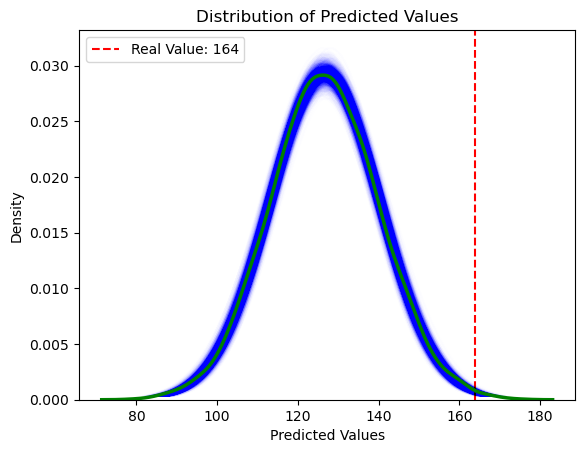

In [5]:
498.9; 33.2; 28.3
reading_df = pd.DataFrame({
    'Sensor_O3': [498.9],
    'Temp': [33.2],
    'RelHum': [28.3]
})

reading_df[columns_to_standardize] = scaler.transform(reading_df[columns_to_standardize])
reading_11_07_18 = reading_df.iloc[0]
print(reading_11_07_18)

pred_samples_11_07_18,m,s = predict_sensor_reading(reading_11_07_18,trace)

# Plotting a vertical line at the mode value
plt.axvline(x=164, color='r', linestyle='--', label=f'Real Value: {164}')

for i in range(len(m)):
    x = np.linspace(m[i] - 3*s[i], m[i] + 3*s[i], 100)

    # Calculate the PDF (Probability Density Function) for these x values
    y = norm.pdf(x, m[i], s[i])

    # Plot the distribution
    plt.plot(x, y,c='b', alpha=0.005)

# Plotting the KDE plot
sns.kdeplot(pred_samples_11_07_18, color='g',linewidth=2.5)

plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Predicted Values')
plt.legend()  # Adding legend to show the mode value
plt.show()





In [6]:
df_11_07_2017 = pd.read_csv('datos-17001.csv', skiprows=range(1, 943), nrows=48, delimiter=';')
df_11_07_2017 = df_11_07_2017.drop('date', axis=1)
df_11_07_2017[columns_to_standardize] = scaler.transform(df_11_07_2017[columns_to_standardize])
x_11_07_2017 = df_11_07_2017.drop('RefSt', axis=1)
y_11_07_2017 = df_11_07_2017['RefSt']

print(x_11_07_2017.head())
print(y_11_07_2017.head())


   Sensor_O3      Temp    RelHum
0  -0.077859 -0.518058 -0.087928
1  -0.177227 -0.610764  0.402681
2  -0.344622 -0.610764  0.506952
3  -0.608773 -0.688019  0.645312
4  -0.698578 -0.760638  0.727525
0    68.0
1    61.0
2    53.0
3    44.0
4    41.0
Name: RefSt, dtype: float64


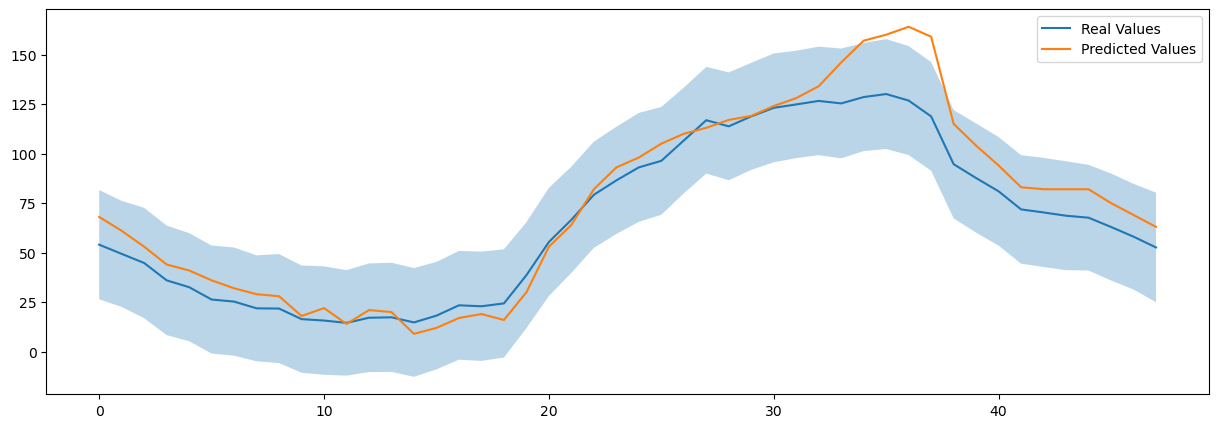

In [7]:
#predict the values for the 48 rows
pred_s_11_07_2017 = []
expected_value = []
credibility_interval = []

for i in range(len(df_11_07_2017)):
    pred_samples_11_07_2017,m,s = predict_sensor_reading(x_11_07_2017.iloc[i],trace)
    pred_s_11_07_2017.append(pred_samples_11_07_2017)
    expected_value.append(np.mean(pred_samples_11_07_2017))
    sigma = np.std(pred_samples_11_07_2017)
    credibility_interval.append([expected_value[i] - 2*sigma, expected_value[i] + 2*sigma])


#plot the credibility interval
plt.figure(figsize=(15, 5))
plt.plot(expected_value, label='Real Values')
plt.plot(y_11_07_2017, label='Predicted Values')
plt.fill_between(range(len(expected_value)), [x[0] for x in credibility_interval], [x[1] for x in credibility_interval], alpha=0.3)
plt.legend()



    



